<h1 style='text-align: center; font-weight: 400'>Decision Tree and Random Forest From Scratch</h1>

<p  style='text-align: center'>
This notebook is in <span style='color: green; font-weight: 700'>Active</span> state of development!
<a style='font-weight:700' href='https://github.com/LilDataScientist'> Code on GitHub! </a></p>

<div style='text-align: center'>
    <img src='https://i.postimg.cc/L41S8ds2/5a1d57465fef77-573085751511872326393.png' width='300' />
</div>

# Understanding how a decision tree works

A decision tree consists of creating different rules by which we make the prediction.
As you can see, decision trees usually have sub-trees that serve to fine-tune the prediction of the previous node. This is so until we get to a node that does not split. This last node is known as a leaf node or leaf node. 

Besides,a decision trees can work for both regression problems and for classification problems. In fact, we will code a decision tree from scratch that can do both.

Now you know the bases of this algorithm, but surely you have doubts. How does the algorithm decide which variable to use as the first cutoff? How do you choose the values? Let’s see it little by little programming our own decision tree from scratch in Python.

## How to find good split?

To find good split you need to know about standart deviation. Basically it is a measure of the amount of variation or dispersion of a set of values. Exaclty what we need. As we want to get more information after every split we need to split data with lower variation or dispersion. For example: if our left split's standart deviation will be very high it means that there are many different values, and we can not be sure what our prediction will be. And when we have low standart deviation that means that all samples are quite similar and then we can take mean of their ouputs for example! 

But how we can compute standart deviation for two parts of data? Well, let's take a sum.

$$\Large
Q = H(R_l) + H(R_r) 
$$

Where $R_l$ is left part, and $R_r$ is right part and $H(x) = \text{standart deviation of x}$ 

Now, let's see how this formula can help us to find better split and you will probably get sense of what's going on under the hood!  

Let's generate some random data:

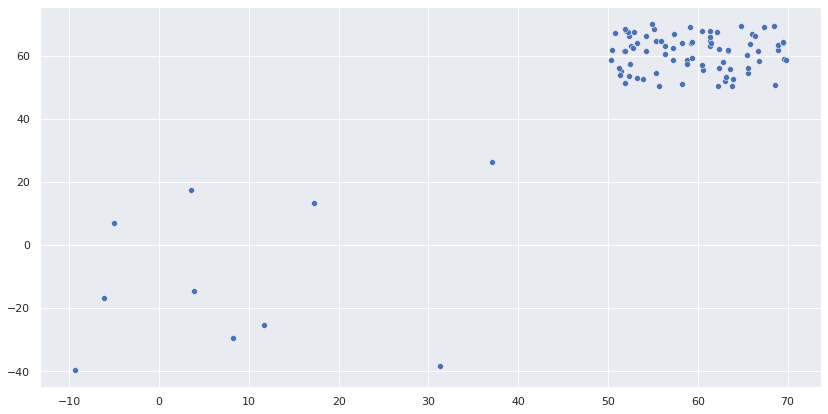

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

sns.set_theme()

np.random.seed(0)

a = np.random.uniform(-40, 40, 10) 
b = np.random.uniform(50, 70, 80)
x_values = np.concatenate((a, b), axis=0)

a = np.random.uniform(-40, 40, 10) 
b = np.random.uniform(50, 70, 80)
y_values = np.concatenate((a, b), axis=0)


fig, ax = plt.subplots(figsize=(14, 7))

sns.scatterplot(x=x_values, y=y_values, ax=ax);

Then let's apply our algorithm (we will map throw each value we can separate parts with and search for the best split with the lowest error)

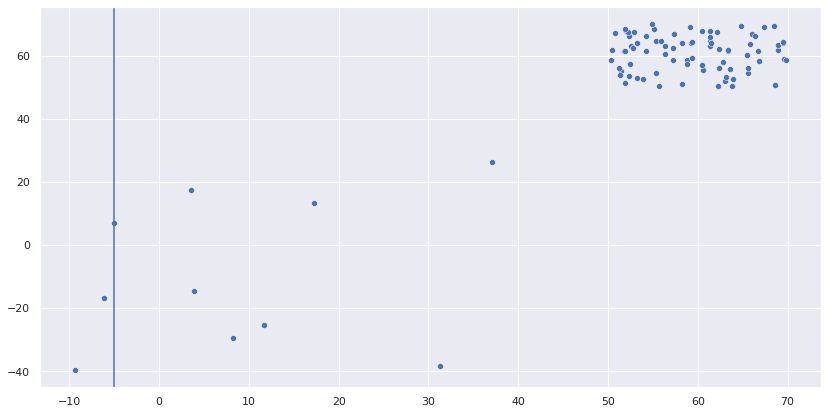

In [2]:
def split_error(X, treshold):
    left, right = np.where(X <= treshold)[0], np.where(X > treshold)[0]
    if len(left) == 0 or len(right) == 0:
        return 10000
    error = np.std(X[left]) + np.std(X[right])
    return error

def best_criteria(X):
    best_treshold = None
    best_error = None
    unique_values = np.unique(X)
    for treshold in unique_values:
        error = split_error(X, treshold)
        if best_error == None or error < best_error:
            best_treshold = treshold
            best_error = error
    return best_treshold, best_error

best_treshold, best_error = best_criteria(x_values)

fig, ax = plt.subplots(figsize=(14, 7))

sns.scatterplot(x=x_values, y=y_values, ax=ax);
plt.axvline(best_treshold, 0, 1);

You can see that it does very bad split. But we did not do any mistake. But we can fix it! The problem here is that algorithm splits the data without respect to the amount of data in split! For example, in previous left split we had oly 3 samples, while in the right split we have almost 100! And our goal is to find split with the lower standart deviation and maximum amount of data in it! 
So, let's penalize errors where small amount of samples! 

$$\Large
Q = \frac{|R_l|}{|R_m|}H(R_l) + \frac{|R_r|}{|R_m|} H(R_r) 
$$

Here we just multiply the standart deviation from the formula above by amount of data in the split! Simple!  

So, why did we do this? - Imagine that we have split where 990 objects goes to the left and 10 go to the right. standart deviation on left part is close to zero, while standart deviation of the right part is HUGE, but, we don't mind having huge deviation for right part as there are only 10 samples of 1000 and in the left part where we have small deviation we have 990!  

Now look how our new algorithm will solve his problem with the same data!

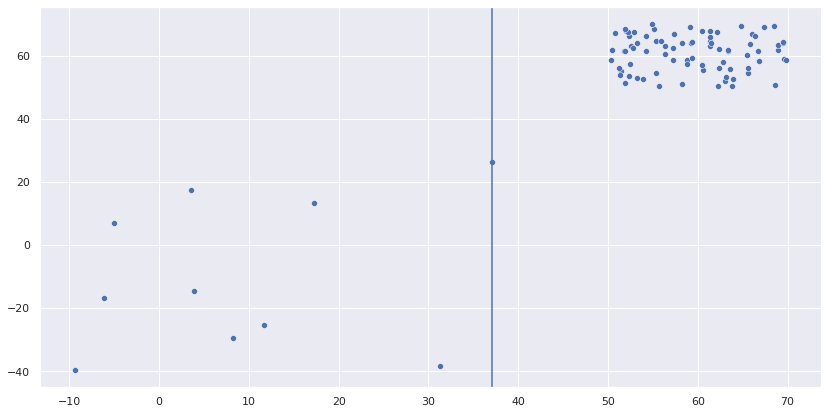

In [3]:
def split_error(X, treshold):
    left, right = np.where(X <= treshold)[0], np.where(X > treshold)[0]
    if len(left) == 0 or len(right) == 0:
        return 10000
    error = len(left) / len(X) * np.std(X[left]) + len(right) / len(X) * np.std(X[right])
    return error

def best_criteria(X):
    best_treshold = None
    best_error = None
    unique_values = np.unique(X)
    for treshold in unique_values:
        error = split_error(X, treshold)
        if best_error == None or error < best_error:
            best_treshold = treshold
            best_error = error
    return best_treshold, best_error

best_treshold, best_error = best_criteria(x_values)

fig, ax = plt.subplots(figsize=(14, 7))

sns.scatterplot(x=x_values, y=y_values, ax=ax);
plt.axvline(best_treshold, 0, 1);

## Implementing base classes

Since **DecisionTreeRegressor** and **DecisionTreeClassifier** have a lot of the same functions we will create a base class and then inherit it instead of coding two huge classes for each

In [4]:
class Node:
    """
    Class that will be used for building tree.
    Linked list basically.
    """
    def __init__(self, left=None, right=None, value=None, feature_idx=None, treshold=None):
        self.left = left
        self.right = right
        self.value = value
        self.feature_idx = feature_idx
        self.treshold = treshold

In [5]:
class Tree:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None
        
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
        
    def predict(self, X):
        return [self.traverse_tree(x, self.tree) for x in X]
    
    def traverse_tree(self, x, node):
        if node.value != None:
            return node.value
        if x[node.feature_idx] <= node.treshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)
    
    def split_error(self, X, feauture_idx, treshold):
        """
        Calculate standart deviation after splitting into 2 groups
        """
        left_idxs, right_idxs = self.split_node(X, feauture_idx, treshold)
        
        if len(X) == 0 or len(left_idxs) == 0 or len(right_idxs) == 0:
            return 10000

        return len(left_idxs) / len(X) * self.standart_deviation(X[left_idxs], feauture_idx) + len(right_idxs) / len(X) * self.standart_deviation(X[right_idxs], feauture_idx)
    
    def standart_deviation(self, X, feauture_idx):
        """
        Calculate standart deviation
        """
        return np.std(X[:, feauture_idx])
    
    def split_node(self, X, feauture_idx, treshold):
        """
        Split into 2 parts
        Splitting a dataset means separating a dataset
        into two lists of rows. Once we have the two 
        groups, we can then use our standart deviation
        score above to evaluate the cost of the split.
        """
        left_idxs  = np.argwhere(X[:, feauture_idx] <= treshold).flatten()
        right_idxs = np.argwhere(X[:, feauture_idx] > treshold).flatten()
        return left_idxs, right_idxs
    
    def best_criteria(self, X, feature_idxs):
        """
        Find best split

        Loop throw each feature, for each feature loop 
        throw each unique value, try each value as a 
        treshold, then choose one, with the smallest error
        """
        best_feauture_idx = None
        best_treshold = None
        best_error = None

        for feature_idx in feature_idxs:
            unique_values = np.unique(X[:, feature_idx])
            for treshold in unique_values:
                error = self.split_error(X, feature_idx, treshold)
                if best_error == None or error < best_error:
                    best_feauture_idx = feature_idx
                    best_treshold = treshold
                    best_error = error

        return best_feauture_idx, best_treshold

## Decision Tree Regressor

Key point of regression task for decision tree is that we want to return mean value on the leaves

In [6]:
class DecisionTreeRegressor(Tree):
    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if depth > self.max_depth or len(X) < self.min_samples_split:
            return Node(value=y.mean())
        
        feature_idxs = np.arange(int(n_features * self.max_features))
        best_feauture_idx, best_treshold = self.best_criteria(X, feature_idxs)
        left_idxs, right_idxs = self.split_node(X, best_feauture_idx, best_treshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return Node(value=y.mean())
        else:
            left = self.grow_tree(X[left_idxs], y[left_idxs], depth + 1)
            right = self.grow_tree(X[right_idxs], y[right_idxs], depth + 1)
            return Node(left=left, right=right, feature_idx=best_feauture_idx, treshold=best_treshold)

## Sigle prediction

Not let's test our algorothm

In [7]:
data = load_boston()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.25)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

MSE: 44.444521493953076


## MSE depending on tree depth

Let's see how does it depen on the depth hyperparameter

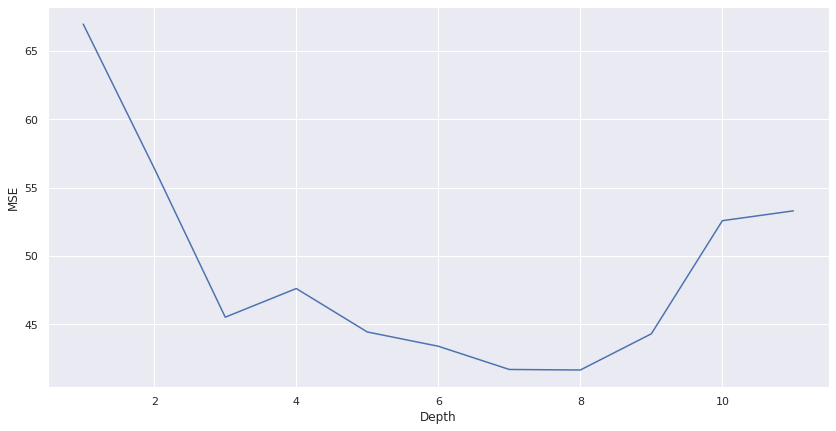

In [8]:
df = pd.DataFrame(columns=['Depth', 'MSE'])

for depth in range(1, 12):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = df.append({'Depth': depth, 'MSE': mean_squared_error(y_test, y_pred)}, ignore_index=True)
    
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=df, x='Depth', y='MSE', ax=ax);

## Decision Tree Classifier

Key point of classification task for decision tree is that we want to return the most frequent class for specific condition

In [9]:
class DecisionTreeClassifier(Tree):
    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if depth > self.max_depth or len(X) < self.min_samples_split:
            counts = np.bincount(y)
            return Node(value=np.argmax(counts))
    
        feature_idxs = np.arange(int(n_features * self.max_features))
        best_feauture_idx, best_treshold = self.best_criteria(X, feature_idxs)
        left_idxs, right_idxs = self.split_node(X, best_feauture_idx, best_treshold)
        
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            counts = np.bincount(y)
            return Node(value=np.argmax(counts))
        else:
            left = self.grow_tree(X[left_idxs], y[left_idxs], depth + 1)
            right = self.grow_tree(X[right_idxs], y[right_idxs], depth + 1)
            return Node(left=left, right=right, feature_idx=best_feauture_idx, treshold=best_treshold)

## Sigle prediction

Not let's test our algorothm

In [10]:
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train);

accuracy_score(y_test, clf.predict(X_test))

0.7333333333333333

# Intuition behind Random Forest

Random forest is an ensemble of decision tree algorithms.

It is an extension of bootstrap aggregation (bagging) of decision trees and can be used for classification and regression problems.

In bagging, a number of decision trees are created where each tree is created from a different bootstrap sample of the training dataset. A bootstrap sample is a sample of the training dataset where a sample may appear more than once in the sample, referred to as sampling with replacement.

Bagging is an effective ensemble algorithm as each decision tree is fit on a slightly different training dataset, and in turn, has a slightly different performance

A prediction on a regression problem is the average of the prediction across the trees in the ensemble. A prediction on a classification problem is the majority vote for the class label across the trees in the ensemble.

## Difference from just bagging

Unlike bagging, random forest also involves selecting a subset of input features (columns or variables) at each split point in the construction of trees. Typically, constructing a decision tree involves evaluating the value for each input variable in the data in order to select a split point. By reducing the features to a random subset that may be considered at each split point, it forces each decision tree in the ensemble to be more different.

In [11]:
def bootstrap_sample(X, y, size):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, size=int(n_samples * size), replace=True)
    return(X[idxs], y[idxs])

In [12]:
class RandomForestRegressor:
    def __init__(self, min_samples_split=2, max_depth=100, n_estimators=5, bootstrap=0.9, max_features=1):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.models = []
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.max_features = max_features

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            X_sample, y_sample = bootstrap_sample(X, y, size=self.bootstrap)
            model = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split, max_features=self.max_features)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        n_samples, n_features = X.shape
        res = np.zeros(n_samples)
        for model in self.models:
            res += model.predict(X)
        return res / self.n_estimators

## Single prediction

Not let's test our algorothm

In [13]:
data = load_boston()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.25)

model = RandomForestRegressor(n_estimators=3,
                                    bootstrap=0.8,
                                    max_depth=10,
                                    min_samples_split=3,
                                    max_features=1)
model.fit(X_train, y_train)
MSE = mean_squared_error(y_test, model.predict(X_test))
print('MSE: {}'.format(MSE))

MSE: 46.111317655779125


## MSE depending on number of trees and features

Let's see how does it depen on the trees hyperparameter

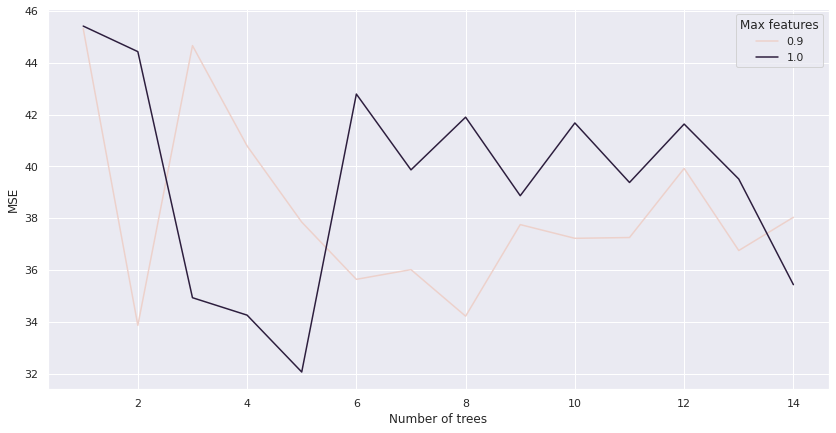

In [14]:
df = pd.DataFrame(columns=['Number of trees', 'MSE', 'Max features'])

for number_of_trees in range(1, 15):
    model = RandomForestRegressor(n_estimators=number_of_trees,
                                    bootstrap=0.9,
                                    max_depth=10,
                                    min_samples_split=3,
                                    max_features=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = df.append({'Number of trees': number_of_trees, 'MSE': mean_squared_error(y_test, y_pred), 'Max features': 1}, ignore_index=True)
    
    model = RandomForestRegressor(n_estimators=number_of_trees,
                                    bootstrap=0.9,
                                    max_depth=10,
                                    min_samples_split=3,
                                    max_features=0.9)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = df.append({'Number of trees': number_of_trees, 'MSE': mean_squared_error(y_test, y_pred), 'Max features': 0.9}, ignore_index=True)
    
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data=df, x='Number of trees', y='MSE', hue='Max features', ax=ax);